# Flood Mapping Analysis for Providence, RI

***

### First, load in all necessary libraries.

In [ ]:
import geopandas as gpd
import pandas as pd
import os
import numpy as np
import rasterio as rio
from pysheds.grid import Grid
import matplotlib.pyplot as plt
from rasterio.mask import mask
from collections import Counter

The tile(s) for the city can either be downloaded from the USGS website, or called via API in Python. Refer to notebook `loading_tiles.ipynb` to get the tile(s) and mosaic them (if needed).

In [314]:
input_tile = "/Users/emmawit/Downloads/USGS_13_n42w072_clipped.tif"
output_dir = "/Users/emmawit/Downloads/ai-final-data/providence-dem-outputs"
os.makedirs(output_dir, exist_ok=True)

base_name = os.path.splitext(os.path.basename(input_tile))[0]

hand_output = os.path.join(output_dir, f"hand_{base_name}.tif")
acc_output = os.path.join(output_dir, f"flow_accum_{base_name}.tif")
fdir_output = os.path.join(output_dir, f"flow_dir_{base_name}.tif")

dirmap = (64, 128, 1, 2, 4, 8, 16, 32)

try:
    with rio.open(input_tile) as dataset:
        if dataset.count == 0:
            print("Input raster has no bands. Skipping.")
        else:
            print(f"Processing: {input_tile}")

            grid = Grid.from_raster(input_tile)
            dem = grid.read_raster(input_tile)

            #### Basic hydrolgoical conditioning ... remove any pits/depressions that may distort data ####
            pit_filled_dem = grid.fill_pits(dem)
            flooded_dem = grid.fill_depressions(pit_filled_dem)
            inflated_dem = grid.resolve_flats(flooded_dem)

            #Flow direction and accumulation
            fdir = grid.flowdir(inflated_dem, dirmap=dirmap)
            acc = grid.accumulation(fdir, dirmap=dirmap)

            #### HAND (Height Above Nearest Drainage) ... make threshold smaller given the size of the city ####
            hand = grid.compute_hand(fdir, dem, acc > 100)

            #### Will be calculated later ... ####
            #threshold = 5  # meters above drainage
            #inundation_extent = np.where(hand < threshold, threshold - hand, np.nan)

            meta = dataset.meta.copy()
            meta.update(dtype=rio.float32, compress='lzw', count=1, nodata=np.nan)

            #### Saving all the outputs so they can be mapped in QGIS ####

            with rio.open(hand_output, 'w', **meta) as dst:
                dst.write(hand.astype(np.float32), 1)
            print(f"HAND written to: {hand_output}")

            with rio.open(acc_output, 'w', **meta) as dst:
                dst.write(acc.astype(np.float32), 1)
            print(f"Flow accumulation written to: {acc_output}")

            with rio.open(fdir_output, 'w', **meta) as dst:
                dst.write(fdir.astype(np.float32), 1)
            print(f"Flow direction written to: {fdir_output}")

except rio.errors.RasterioIOError:
    print(f"Could not open input raster: {input_tile}")
except Exception as e:
    print(f"Error processing tile: {e}")

Processing: /Users/emmawit/Downloads/USGS_13_n42w072_clipped.tif
HAND written to: /Users/emmawit/Downloads/ai-final-data/providence-dem-outputs/hand_USGS_13_n42w072_clipped.tif
Flow accumulation written to: /Users/emmawit/Downloads/ai-final-data/providence-dem-outputs/flow_accum_USGS_13_n42w072_clipped.tif
Flow direction written to: /Users/emmawit/Downloads/ai-final-data/providence-dem-outputs/flow_dir_USGS_13_n42w072_clipped.tif


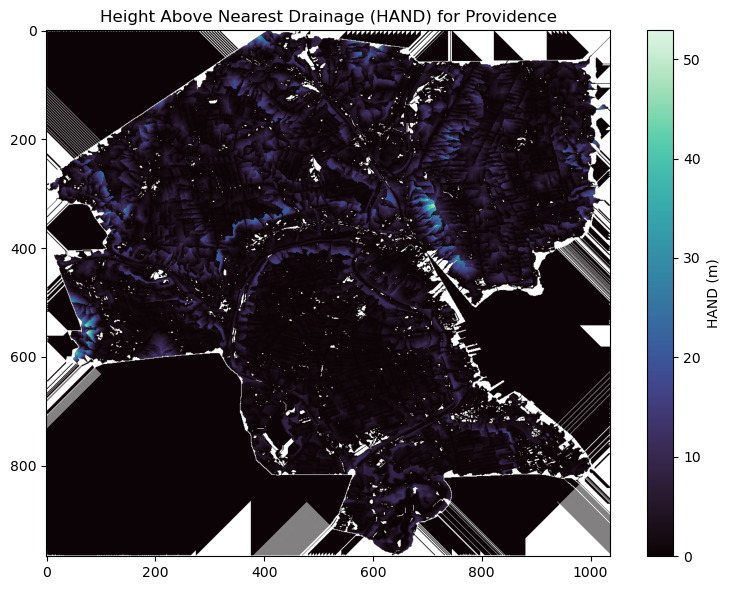

Fixed HAND model saved to: /Users/emmawit/Downloads/ai-final-data/providence-dem-outputs/hand-PROV-fixed.tif


In [315]:
#### Fixing the HAND model ... keeping values within reasonable range, could be some noise in the data ####
hand_fixed = np.where((hand >= 0) & (hand <= 100), hand, np.nan)

#### Save for mapping ... ####
output_path = "/Users/emmawit/Downloads/ai-final-data/providence-dem-outputs/hand-PROV-fixed.tif"

meta = {
    'driver': 'GTiff',
    'count': 1,
    'dtype': 'float32',
    'crs': 'EPSG:4326',  
    'width': hand.shape[1],
    'height': hand.shape[0],
    'transform': grid.affine  
}

with rasterio.open(output_path, 'w', **meta) as dst:
    dst.write(hand_fixed, 1)

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(hand_fixed, cmap='mako')

plt.colorbar(im, label='HAND (m)')

plt.title('Height Above Nearest Drainage (HAND) for Providence')
plt.tight_layout()

plt.show()

print(f"Fixed HAND model saved to: {output_path}")

***

## Creating Indunation using the HAND Model

From the previous step, we use the HAND Model output to create inundation rasters for specific inundation thresholds. The inundation calculation was altered to accommodate the 'fixed' HAND Model. The code chunk after this saves the output as a .tif, which is use for further analysis and mapping. Repeat these two code chunks to replicate inundation rasters for 0.5,  1, 2, 3, 4, and 5 Meter (m) thresholds.

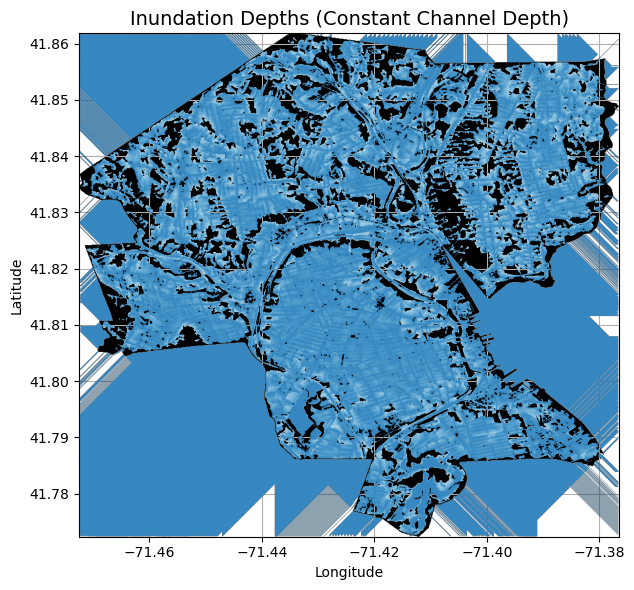

In [316]:
threshold = 5  
inundation_extent = np.where((hand >= 0) & (hand < threshold), threshold - hand, np.nan)

fig, ax = plt.subplots(figsize=(8, 6))
fig.patch.set_alpha(0)

dem_view = grid.view(dem, nodata=np.nan)

plt.imshow(dem_view, extent=grid.extent, cmap='Greys', zorder=1)
plt.imshow(inundation_extent, extent=grid.extent,
           cmap='Blues', vmin=-5, vmax=10, zorder=2)
plt.grid(zorder=0)
plt.title('Inundation Depths (Constant Channel Depth)', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.show()

In [327]:
import rasterio as rio
import numpy as np

# Path to your DEM (for metadata)
dem_path = "/Users/emmawit/Downloads/USGS_13_n42w072_clipped.tif"

# Output path for inundation raster
output_path = "/Users/emmawit/Downloads/ai-final-data/providence-inundation/5m-prov.tif"

# Make sure the array is float32 and masked properly
inundation_to_save = inundation_extent.astype("float32")

# Load DEM metadata
with rio.open(dem_path) as src:
    meta = src.meta.copy()
    meta.update({
        "dtype": "float32",
        "nodata": np.nan,
        "count": 1
    })

# Write inundation extent raster
with rio.open(output_path, "w", **meta) as dst:
    dst.write(inundation_to_save, 1)

print(f"Inundation extent raster saved to: {output_path}")

Inundation extent raster saved to: /Users/emmawit/Downloads/ai-final-data/providence-inundation/5m-prov.tif


***

To reduce the chances of extreme values or improper calculations, the inundation rasters are clipped to the city's boundaries. Re-run the code chunks for all six threshold values.

#### Likewise, the code below provides the inundation area (in km^2) and the total coverage (%) of the city.

Clipped raster saved to: /Users/emmawit/Downloads/ai-final-data/providence-inundation/5m-prov-clipped.tif


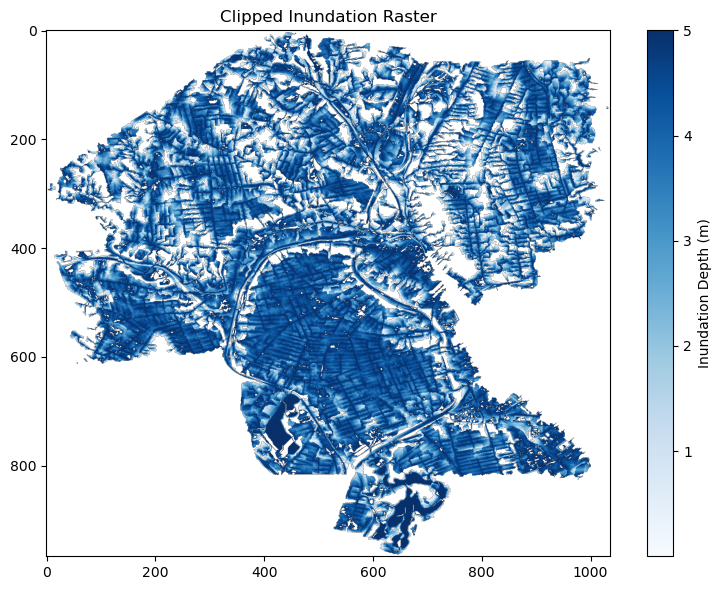

In [276]:
inundation_path = "/Users/emmawit/Downloads/ai-final-data/providence-inundation/5m-prov.tif"
boundary_shapefile_path = "/Users/emmawit/Downloads/PVD_Boundary/PVD_Boundary.shp"

boundary_gdf = gpd.read_file(boundary_shapefile_path)

with rasterio.open(inundation_path) as src:
    raster_crs = src.crs
    
    if boundary_gdf.crs != raster_crs:
        boundary_gdf = boundary_gdf.to_crs(raster_crs)

    geoms = boundary_gdf.geometry.values 

    out_image, out_transform = mask(src, geoms, crop=True)

    out_meta = src.meta.copy()
    out_meta.update({
        "driver": "GTiff",
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform
    })

output_path = "/Users/emmawit/Downloads/ai-final-data/providence-inundation/5m-prov-clipped.tif"
with rasterio.open(output_path, 'w', **out_meta) as dest:
    dest.write(out_image)

print(f"Clipped raster saved to: {output_path}")

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(out_image[0], cmap='Blues')
plt.colorbar(im, label='Inundation Depth (m)')
plt.title('Clipped Inundation Raster')
plt.tight_layout()
plt.show()

Clipped raster saved to: /Users/emmawit/Downloads/5m-prov-clipped-TEST.tif
Inundated area: 12.62 km²
Total Providence area: 50.93 km²
Percentage of Providence inundated: 24.78%


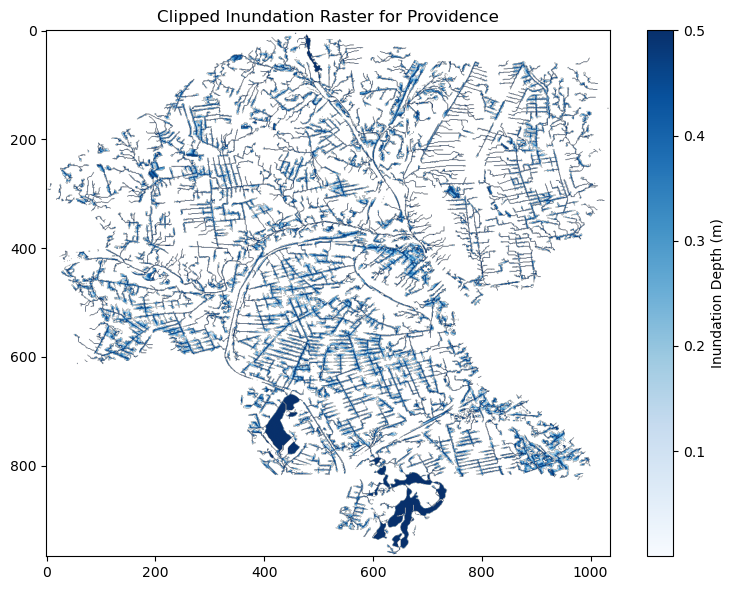

In [324]:
inundation_path = "/Users/emmawit/Downloads/ai-final-data/providence-inundation/0_5m-prov.tif"
boundary_shapefile_path = "/Users/emmawit/Downloads/PVD_Boundary/PVD_Boundary.shp"
output_path = "/Users/emmawit/Downloads/5m-prov-clipped-TEST.tif"

boundary_gdf = gpd.read_file(boundary_shapefile_path)

with rasterio.open(inundation_path) as src:
    raster_crs = src.crs
    if boundary_gdf.crs != raster_crs:
        boundary_gdf = boundary_gdf.to_crs(raster_crs)

    geoms = boundary_gdf.geometry.values
    out_image, out_transform = mask(src, geoms, crop=True)
    
    out_meta = src.meta.copy()
    out_meta.update({
        "driver": "GTiff",
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform
    })

with rasterio.open(output_path, 'w', **out_meta) as dest:
    dest.write(out_image)

print(f"Clipped raster saved to: {output_path}")

pixel_width = abs(out_transform[0])  
pixel_height = abs(out_transform[4]) 
pixel_area_deg2 = pixel_width * pixel_height

inundated_pixels = np.sum(out_image[0] > 0)

boundary_projected = boundary_gdf.to_crs(epsg=26930)  #### Rhode Island (EPSG:26930) ####
total_area_m2 = boundary_projected.geometry.area.sum()

meters_per_degree_lat = 111_000  
meters_per_degree_lon = 111_000 * np.cos(np.deg2rad(41.82))  

pixel_area_m2 = meters_per_degree_lat * meters_per_degree_lon * pixel_area_deg2

inundated_area_m2 = inundated_pixels * pixel_area_m2

percentage_inundated = (inundated_area_m2 / total_area_m2) * 100

print(f"Inundated area: {inundated_area_m2/1e6:.2f} km²")
print(f"Total Providence area: {total_area_m2/1e6:.2f} km²")
print(f"Percentage of Providence inundated: {percentage_inundated:.2f}%")

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(out_image[0], cmap='Blues')
plt.colorbar(im, label='Inundation Depth (m)')
plt.title('Clipped Inundation Raster for Providence')
plt.tight_layout()
plt.show()

***

## Determine the **Land Use Distribution** Throughout the City

Which land use types are more common throughout the city and what is the percent distribution?

Class 11: 1.52%
Class 21: 7.33%
Class 22: 12.56%
Class 23: 47.02%
Class 24: 30.09%
Class 41: 1.10%
Class 71: 0.05%
Class 90: 0.20%
Class 95: 0.12%


/var/folders/_6/7_dyppvx4kl54x9k8qfyyzz80000gn/T/ipykernel_15591/364924343.py:87: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(labels, fontsize=8, fontname='Eina02-Regular')


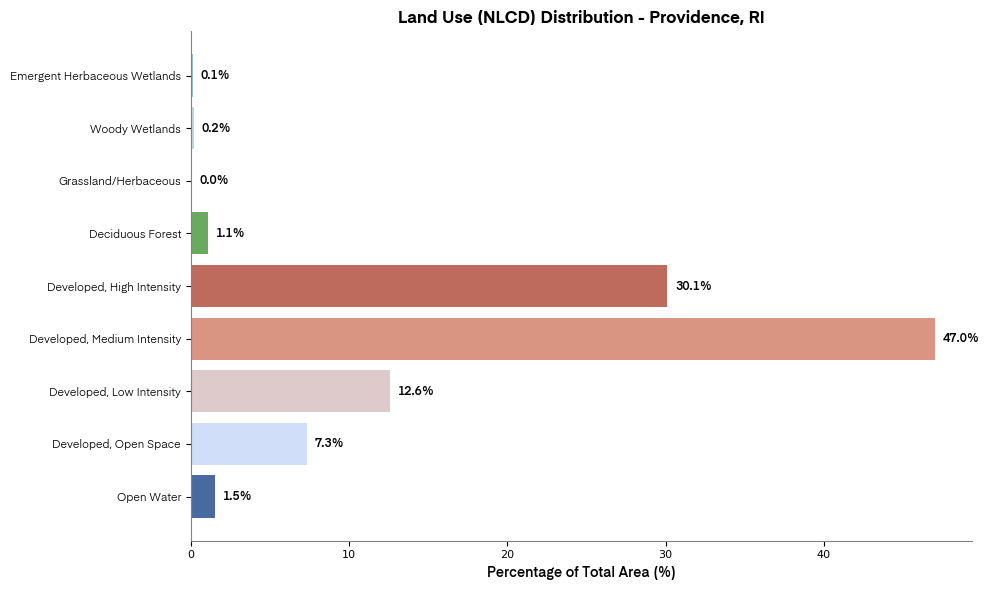

In [277]:
with rasterio.open("/Users/emmawit/Downloads/providence_landuse.tif") as src:
    land_use = src.read(1) 
    nodata = src.nodata

land_use_clean = land_use[land_use != nodata]

counts = Counter(land_use_clean)

total_pixels = sum(counts.values())

percentages = {cls: (count / total_pixels) * 100 for cls, count in counts.items()}

for cls in sorted(percentages):
    print(f"Class {cls}: {percentages[cls]:.2f}%")


#### Label each category to match the NLCD ####
nlcd_labels = {
    11: 'Open Water',
    21: 'Developed, Open Space',
    22: 'Developed, Low Intensity',
    23: 'Developed, Medium Intensity',
    24: 'Developed, High Intensity',
    31: 'Barren Land',
    41: 'Deciduous Forest',
    42: 'Evergreen Forest',
    43: 'Mixed Forest',
    52: 'Shrub/Scrub',
    71: 'Grassland/Herbaceous',
    81: 'Pasture/Hay',
    82: 'Cultivated Crops',
    90: 'Woody Wetlands',
    95: 'Emergent Herbaceous Wetlands'
}

#### All Formating Graph ####

nlcd_colors = {
    11: '#476ba1',   # Open Water
    21: '#d1defa',   # Developed, Open Space
    22: '#decaca',   # Developed, Low Intensity
    23: '#d99482',   # Developed, Medium Intensity
    24: '#be6b5d',   # Developed, High Intensity
    31: '#b2ada0',   # Barren Land
    41: '#68ab5f',   # Deciduous Forest
    42: '#1c6330',   # Evergreen Forest
    43: '#b5c58f',   # Mixed Forest
    52: '#a58c30',   # Shrub/Scrub
    71: '#dcd939',   # Grassland/Herbaceous
    81: '#ab6c28',   # Pasture/Hay
    82: '#dca85d',   # Cultivated Crops
    90: '#bad8ea',   # Woody Wetlands
    95: '#94c4d6'    # Emergent Herbaceous Wetlands
}

classes = sorted(percentages)
labels = [nlcd_labels.get(cls, f"Class {cls}") for cls in classes]
values = [percentages[cls] for cls in classes]
colors = [nlcd_colors.get(cls, 'gray') for cls in classes] 

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(labels, values, color=colors)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('grey')
ax.spines['left'].set_color('grey')

for bar in bars:
    width = bar.get_width()
    ax.text(width + 0.5, bar.get_y() + bar.get_height() / 2,
            f"{width:.1f}%", va='center', fontsize=9, fontname='Eina02-SemiBold')

ax.set_xlabel('Percentage of Total Area (%)', fontname='Eina02-SemiBold')
ax.set_title('Land Use (NLCD) Distribution - Providence, RI', fontname='Eina02-Bold')
ax.set_yticklabels(labels, fontsize=8, fontname='Eina02-Regular')
ax.tick_params(axis='x', labelsize=8) 
plt.grid(axis='x', linestyle=' ', alpha=0.5)
plt.tight_layout()

#### Save Graph ####

output_path = "/Users/emmawit/Downloads/ai-final-data/providence-inundation-landuse/landuse-distribution-providence.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight') 

plt.show()


***

## Calculate which **Land Use** type (%) Falls within each **Inundation Threshold**

Which land use types are more vulnerable to flooding? As such, what is the percent composition of the land use that falls 'under' each indunation threshold that was previously calculated? The code below needs to be re-run for each threshold. 

Land Use Percentages Within Flooded Area:
Unknown (Class 0): 0.00%
Open Water (Class 11): 4.71%
Developed, Open Space (Class 21): 4.88%
Developed, Low Intensity (Class 22): 8.28%
Developed, Medium Intensity (Class 23): 42.18%
Developed, High Intensity (Class 24): 39.17%
Deciduous Forest (Class 41): 0.18%
Grassland/Herbaceous (Class 71): 0.02%
Woody Wetlands (Class 90): 0.40%
Emergent Herbaceous Wetlands (Class 95): 0.18%


/var/folders/_6/7_dyppvx4kl54x9k8qfyyzz80000gn/T/ipykernel_15591/4047251439.py:120: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(labels, fontsize=8, fontname='Eina02-Regular')


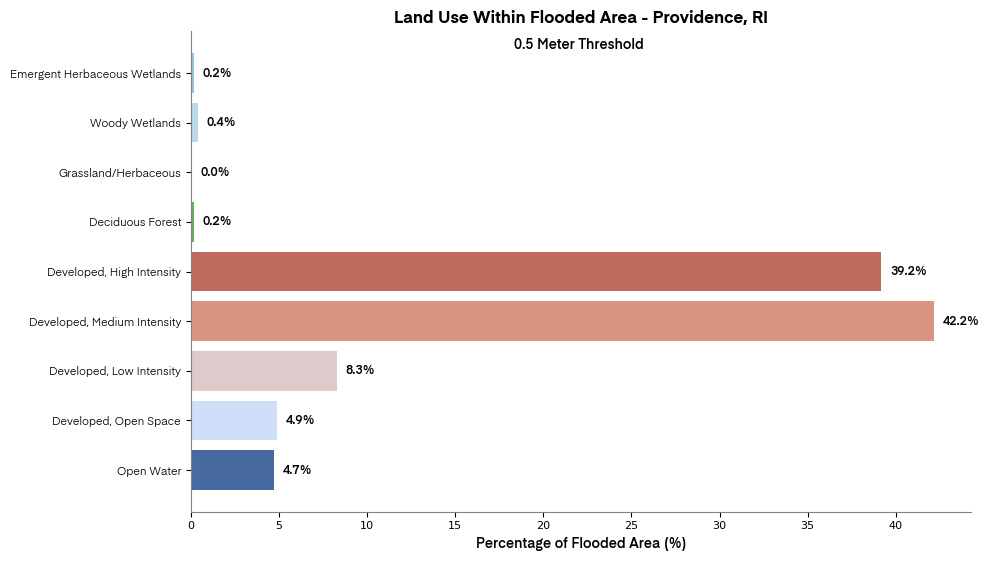

In [322]:
nlcd_path = "/Users/emmawit/Downloads/providence_landuse.tif"
inundation_path = "/Users/emmawit/Downloads/ai-final-data/providence-inundation/0_5m-prov-clipped.tif"

with rasterio.open(inundation_path) as flood_src:
    inundation = flood_src.read(1)
    flood_mask = ~np.isnan(inundation)
    flood_meta = flood_src.meta.copy()

with rasterio.open(nlcd_path) as nlcd_src:
    nlcd_data = nlcd_src.read(1)
    nlcd_nodata = nlcd_src.nodata

    nlcd_resampled = np.empty_like(inundation, dtype=nlcd_data.dtype)

    reproject(
        source=nlcd_data,
        destination=nlcd_resampled,
        src_transform=nlcd_src.transform,
        src_crs=nlcd_src.crs,
        dst_transform=flood_meta["transform"],
        dst_crs=flood_meta["crs"],
        resampling=Resampling.nearest
    )

flooded_land_use = nlcd_resampled[flood_mask]
flooded_land_use = flooded_land_use[flooded_land_use != nlcd_nodata]

counts = Counter(flooded_land_use)
total = sum(counts.values())
percentages = {cls: (count / total) * 100 for cls, count in counts.items()}

nlcd_labels = {
    11: 'Open Water',
    21: 'Developed, Open Space',
    22: 'Developed, Low Intensity',
    23: 'Developed, Medium Intensity',
    24: 'Developed, High Intensity',
    31: 'Barren Land',
    41: 'Deciduous Forest',
    42: 'Evergreen Forest',
    43: 'Mixed Forest',
    52: 'Shrub/Scrub',
    71: 'Grassland/Herbaceous',
    81: 'Pasture/Hay',
    82: 'Cultivated Crops',
    90: 'Woody Wetlands',
    95: 'Emergent Herbaceous Wetlands'
}

########

print("Land Use Percentages Within Flooded Area:")
for cls in sorted(percentages):
    label = nlcd_labels.get(cls, "Unknown")
    print(f"{label} (Class {cls}): {percentages[cls]:.2f}%")

percentages_filtered = {cls: pct for cls, pct in percentages.items() if cls != 0}

classes = sorted(percentages_filtered)
labels = [nlcd_labels.get(cls, f"Class {cls}") for cls in classes]
values = [percentages_filtered[cls] for cls in classes]

#### Custom color mapping to match the colors of the NLCD ... ####
nlcd_colors = {
    11: '#476ba1',   # Open Water
    21: '#d1defa',   # Developed, Open Space
    22: '#decaca',   # Developed, Low Intensity
    23: '#d99482',   # Developed, Medium Intensity
    24: '#be6b5d',   # Developed, High Intensity
    31: '#b2ada0',   # Barren Land
    41: '#68ab5f',   # Deciduous Forest
    42: '#1c6330',   # Evergreen Forest
    43: '#b5c58f',   # Mixed Forest
    52: '#a58c30',   # Shrub/Scrub
    71: '#dcd939',   # Grassland/Herbaceous
    81: '#ab6c28',   # Pasture/Hay
    82: '#dca85d',   # Cultivated Crops
    90: '#bad8ea',   # Woody Wetlands
    95: '#94c4d6'    # Emergent Herbaceous Wetlands
}

colors = [nlcd_colors.get(cls, '#808080') for cls in classes]  

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(labels, values, color=colors)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('grey')
ax.spines['left'].set_color('grey')

for bar in bars:
    width = bar.get_width()
    ax.text(width + 0.5, bar.get_y() + bar.get_height() / 2,
            f"{width:.1f}%", va='center', fontsize=9, fontname='Eina02-SemiBold')

ax.set_xlabel('Percentage of Flooded Area (%)', fontname='Eina02-SemiBold')
ax.set_title('Land Use Within Flooded Area - Providence, RI', fontname='Eina02-Bold')
ax.set_yticklabels(labels, fontsize=8, fontname='Eina02-Regular')
ax.tick_params(axis='x', labelsize=8) 

plt.suptitle('0.5 Meter Threshold', fontsize=10, fontstyle='italic', y=0.88, x=0.584, fontname='Eina02-SemiBold')

plt.tight_layout()
plt.grid(axis='x', linestyle=' ', alpha=0.5)

#### Can save graph output ... ####
#output_path = "/Users/emmawit/Downloads/ai-final-data/providence-inundation-landuse/providence_0_5m.png"
#plt.savefig(output_path, dpi=300, bbox_inches='tight') 

plt.show()

***

## Calculate % of **Predominanent Race Group** per Block Group

For this portion, ACS Block Groups were collected for each city. Given the scale of the study areas, these specific geometries were selected. First, for basic exploratory purposes, this gives a simple graph and calculate composition of predominanent race groups along the block groups, and total % compositions. 

                            Race Group  Percentage
0                   Hispanic or Latino   62.091503
1  White alone, not Hispanic or Latino   37.908497


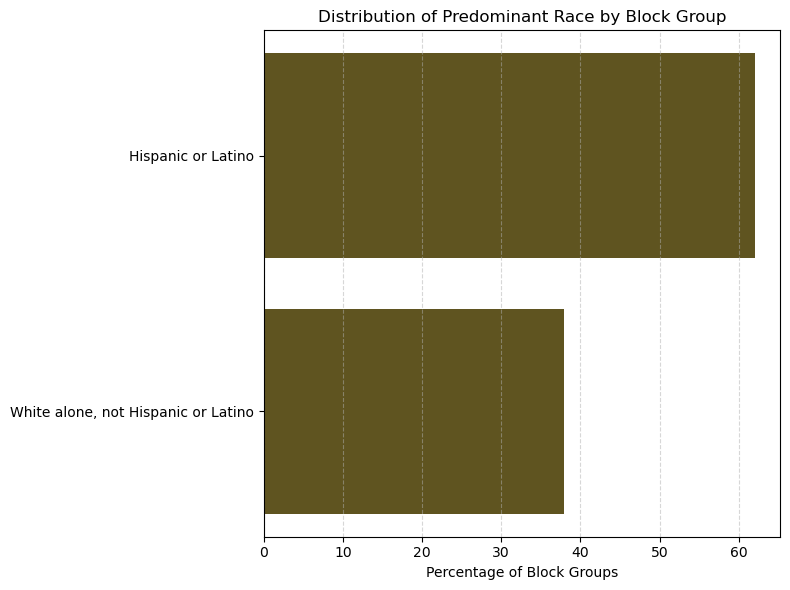

In [311]:
gdf = gpd.read_file("/Users/emmawit/Downloads/providence_race_blocks/P_b_r.shp")

race_series = gdf['P009_ca_22'].dropna()

race_counts = race_series.value_counts()

#### Calculate percentages ####
race_percentages = (race_counts / race_counts.sum()) * 100

race_df = race_percentages.reset_index()
race_df.columns = ['Race Group', 'Percentage']

print(race_df)

fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.barh(race_df['Race Group'], race_df['Percentage'], color='#5f5420')
ax.set_xlabel("Percentage of Block Groups")
ax.set_title("Distribution of Predominant Race by Block Group")
plt.gca().invert_yaxis()  # Highest first
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

***

## Calculate which **Race Group** (and %) Falls within each **Inundation Threshold**

See which race groups are more vulnerable to each inundation threshold. Inundation ranges from 0.5 to 5 m to gain a more comprehensive view. The code chunk only calculates rates one at a time, therefore `inundation_path` needs to be replaced for each threshold. 

Flooded Area by Race Group:
Hispanic or Latino: 271233 pixels, 0.00 km², 56.48% of flooded area
White alone, not Hispanic or Latino: 207134 pixels, 0.00 km², 43.13% of flooded area


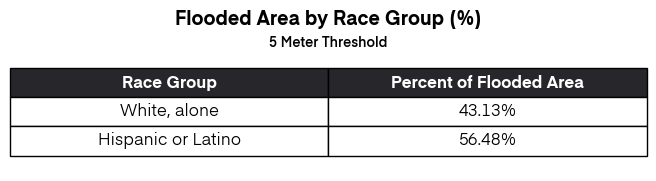

In [310]:
import geopandas as gpd
import rasterio
import numpy as np
from rasterio.features import rasterize
from shapely.geometry import mapping
from collections import defaultdict

shapefile_path = "/Users/emmawit/Downloads/providence_race_blocks/P_b_r.shp"
inundation_path = "/Users/emmawit/Downloads/ai-final-data/providence-inundation/5m-prov-clipped.tif"

gdf = gpd.read_file(shapefile_path)

#### Loading in the inundation raster ####
with rasterio.open(inundation_path) as src:
    inundation = src.read(1)
    flood_mask = ~np.isnan(inundation)
    transform = src.transform
    shape = inundation.shape
    pixel_area = abs(transform[0] * transform[4])  

#### Reproject ####
gdf = gdf.to_crs(src.crs)

#### Each Race Cat. ####
race_categories = gdf["P009_ca_22"].unique()

flooded_pixel_counts = {}

#### Loop for each race ####
for race in race_categories:
    sub_gdf = gdf[gdf["P009_ca_22"] == race]

    if sub_gdf.empty:
        continue

    shapes = ((geom, 1) for geom in sub_gdf.geometry)
    race_raster = rasterize(
        shapes,
        out_shape=shape,
        transform=transform,
        fill=0,
        dtype='uint8'
    )

    flooded_pixels = np.logical_and(flood_mask, race_raster == 1)
    flooded_count = np.count_nonzero(flooded_pixels)
    flooded_pixel_counts[race] = flooded_count

total_flooded_pixels = np.count_nonzero(flood_mask)

print("Flooded Area by Race Group:")
for race, count in flooded_pixel_counts.items():
    percent = (count / total_flooded_pixels) * 100
    area_km2 = count * pixel_area / 1e6
    print(f"{race}: {count} pixels, {area_km2:.2f} km², {percent:.2f}% of flooded area")

###############################

import pandas as pd
import matplotlib.pyplot as plt

#### For styling purposes, data has to be manually entered after calculation ... ####
data = {
    "Race Group": ["White, alone", "Hispanic or Latino"],
    "Percent of Flooded Area": ["43.13%", "56.48%"]
}

df_manual = pd.DataFrame(data)

fig, ax = plt.subplots(figsize=(8, len(df_manual)*0.6 + 1))
ax.axis('off')

table = ax.table(
    cellText=df_manual.values,
    colLabels=df_manual.columns,
    cellLoc='center',
    loc='center',
    colColours=['#f7f7f7'] * len(df_manual.columns)
)

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.6, 2.5)

for (row, col), cell in table.get_celld().items():
    if row == 0:  
        cell.set_text_props(fontname='Eina02-Bold', color='white')
        cell.set_facecolor('#27272b') 
    else: 
        cell.set_text_props(fontname='Eina02-Regular')

plt.title("Flooded Area by Race Group (%)", fontsize=14, pad=20, fontname='Eina02-Bold')
plt.suptitle('5 Meter Threshold', fontsize=10, fontstyle='italic', y=0.68, x=0.5, fontname='Eina02-SemiBold')
plt.tight_layout()

#If you want to download the output...
#output_path = "/Users/emmawit/Downloads/ai-final-data/providence-inundation-demographics/race-flood-prov-5m.png"
#plt.savefig(output_path, dpi=300, bbox_inches='tight') 

plt.show()